Project Analysis

For this binary classification problem, I decided to choose from Naive Bayes and SVM.
Because dataset is highly correlated, it would not be rational to use Random Forest or Decision Trees 
as they cannot work to full potential with multicollinearity.


In [2]:
import pandas, numpy
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [3]:
training_set = pandas.read_csv("training_set.csv")
validation_set = pandas.read_csv('validation_set.csv')
testing_set = pandas.read_csv("testing_set.csv")

print(len(training_set), len(validation_set), len(testing_set))


209410 209410 418820


In [4]:
for dataset in [training_set, testing_set, validation_set]:
    dataset.drop(columns=['client_id', 'Unnamed: 0'], inplace=True)

Correlation between features

<Axes: >

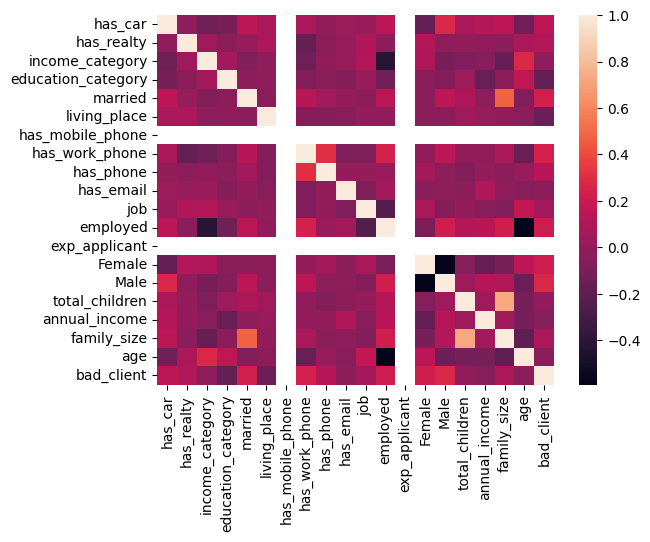

In [5]:
sns.heatmap(training_set.corr())

Initializing XG Boost Classifier

In [6]:
xg_model = xgb.XGBClassifier()

Lets evaluate basic performance on evaluation set

In [7]:
from sklearn.model_selection import train_test_split

x, y = training_set.drop(columns=['bad_client']), training_set['bad_client']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, stratify=y)


In [8]:
eval_set = [(x_train, y_train), (x_test, y_test)]

%time xg_model.fit(x_train, y_train, eval_set=eval_set, verbose=10000)

[0]	validation_0-logloss:0.49933	validation_1-logloss:0.49947
[99]	validation_0-logloss:0.01025	validation_1-logloss:0.01170
CPU times: user 26.2 s, sys: 5.23 s, total: 31.4 s
Wall time: 4.47 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
# setting up some basic hyperparameters to set optimization baseline
xg_model = xgb.XGBClassifier(
    scale_pos_weight=1,
    learning_rate=0.01,  
    colsample_bytree = 0.4,
    subsample = 0.8,
    objective='binary:logistic', 
    n_estimators=1000, 
    reg_alpha = 0.3,
    max_depth=4, 
    gamma=10
)

Hyperparameter Tuning for XGBoost Model using GridSearchCV on validation set

In [36]:
# Selecting models and apply hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss

x_training, y_training = validation_set.drop(columns=['bad_client']), validation_set['bad_client']

loss_function = make_scorer(
    log_loss, greater_is_better=False, 
    needs_proba=True
)

xg_hyperparams = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

new_cvs = RandomizedSearchCV(
    estimator=xg_model,
    param_distributions=xg_hyperparams,
    scoring=loss_function,
    cv=StratifiedKFold(n_splits=5),
    error_score="raise",
    n_jobs=-1,
)

new_cvs.fit(x_training, y_training)
    
    # the lower loss score is, the better model performs 

optimal_params = new_cvs.best_params_
loss_score = new_cvs.best_score_

opt_model = xgb.XGBClassifier(**optimal_params)

hp_features = sorted({
    training_set.columns[feature]: opt_model.feature_importances_[feature]
    for feature in range(len(training_set.columns))
}, key=lambda key: hp_features[key], reverse=True)

hp_features


[17:00:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[17:00:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[17:00:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[17:00:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[17:00:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[17:00:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpytho

KeyboardInterrupt: 

Feature Selection using RFE (Recursive Feature Elimination) using validation set

In [35]:
from sklearn.feature_selection import RFECV

x_validation = validation_set.drop(columns=['bad_client'])
y_validation = validation_set['bad_client']

# feature selector
estimator = RFECV(
    estimator=opt_model, 
    step=2, min_features_to_select=5,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
)

# fitting the model 
estimator.fit(x_validation, y_validation)
    
features_idxs = list(
    filter(
        lambda feature: estimator.support_[feature] == True,
        range(len(x_validation.columns))
    )
)

feature_func = (lambda feature: training_set[0].columns[feature])

res = {
    'features': feature_func(features_idxs),
    'metrics': numpy.mean(estimator.cv_results_['mean_test_score'])    
}
res

important_features = res['features']

print(hp_features.keys())
print(important_features)


{'features': Index(['has_car', 'has_realty', 'income_category', 'education_category',
        'married', 'living_place', 'has_work_phone', 'has_phone', 'has_email',
        'job', 'employed', 'Female', 'Male', 'total_children', 'age',
        'annual_income', 'family_size'],
       dtype='object'),
 'metrics': 0.982954347117384}

Splitting important data for testing set

In [ ]:
testing_set = testing_set[important_features]

Cross-validating model on testing set

In [40]:
from sklearn.model_selection import cross_validate 


x_testing, y_testing = testing_set.drop(columns=['bad_client']), testing_set['bad_client']
scorers = ["precision", "recall", "accuracy"]

scores = cross_validate(
    estimator=opt_model,
    X=x_testing,
    y=y_testing,
    scoring=scorers
)

print('accuracy - ', numpy.mean(scores['test_accuracy']))
print('precision - ', numpy.mean(scores['test_precision']))
print('recall - ', numpy.mean(scores['test_recall']))

NameError: name 'opt_model' is not defined

Saving model

In [257]:
# saving machine learning model using pickle 
import pickle 
pickle.dump(opt_model, open("classifier.pkl", mode="wb"))